In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import torch.optim as optim
from tqdm import tqdm
import os
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

sns.set_theme()

In [6]:
df = pd.read_parquet("covid_mentions_equal_clean.parquet")
df.index = df.index.droplevel()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("trump", axis=1),
    df["trump"],
    stratify=df["trump"],
    test_size=0.2,
    random_state=42,
)

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [8]:
train_words = X_train.clean_lines.str.split().explode()
n_train_unique = train_words.nunique()

In [9]:
N = 5000
tw = train_words.value_counts()[:N]
pd.DataFrame({"word": tw.index, "count": tw})

,word,count
the,the,228205
to,to,119216
of,of,99323
and,and,90433
in,in,76510
...,...,...
shoulder,shoulder,40
projection,projection,40
humanitarian,humanitarian,40
franchise,franchise,40


In [7]:
wd = {word: count for word, count in zip(tw.index, tw)}
with open("word_counts_5k.pkl", "wb") as f:
    pickle.dump(wd, f)

In [21]:
words_cdf[5000]

0.9477492772550524

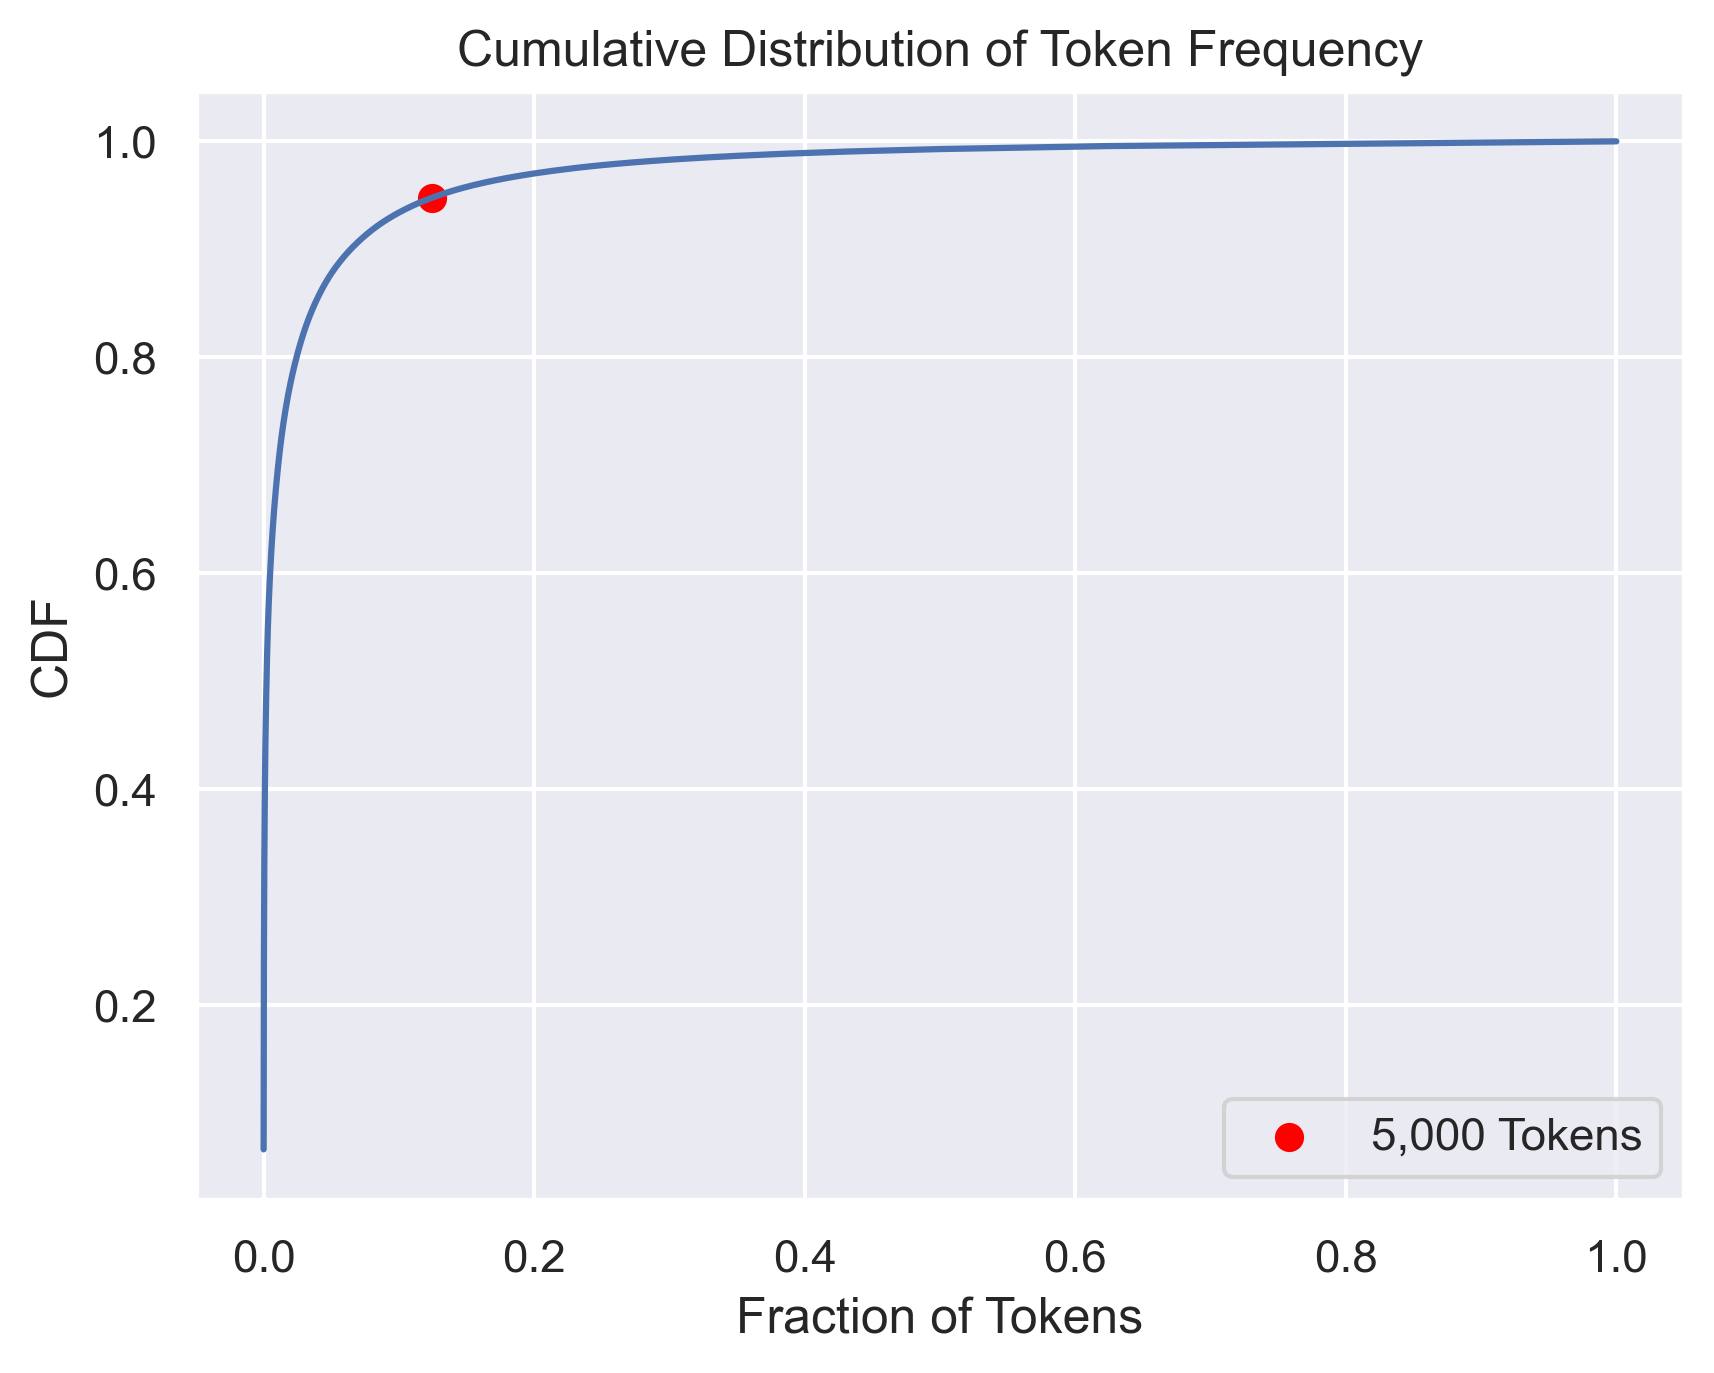

In [24]:
words_cdf = train_words.value_counts().cumsum() / len(train_words)
plt.figure(dpi=300)
plt.plot(np.linspace(0, 1, len(words_cdf)), words_cdf)
plt.xlabel("Fraction of Tokens")
plt.ylabel("CDF")
plt.title("Cumulative Distribution of Token Frequency")
plt.scatter(5000 / len(words_cdf), words_cdf[5000], color="red", label="5,000 Tokens")
plt.legend()

In [25]:
X_train_tfidf_v = TfidfVectorizer(max_features=5000)
X_train_tfidf = X_train_tfidf_v.fit_transform(X_train.clean_lines)
X_test_tfidf = X_train_tfidf_v.transform(X_test.clean_lines)

In [204]:
fp = [
    b
    for b, _ in list(
        zip(nb_count.feature_count_[0], X_train_count_v.get_feature_names())
    )
]
tp = [
    a
    for a, _ in list(
        zip(nb_count.feature_count_[1], X_train_count_v.get_feature_names())
    )
]

In [205]:
pd.DataFrame(
    {"word": X_train_count_v.get_feature_names(), "not_trump": fp, "trump": tp}
).to_parquet("word_counts.parquet")

In [66]:
X_train_count_v = CountVectorizer(max_features=5000)
X_train_count = X_train_count_v.fit_transform(X_train.clean_lines)
X_test_count = X_train_count_v.transform(X_test.clean_lines)

# with open("cv_10k.pkl", "wb") as f:
#     pickle.dump(X_train_count_v, f)

In [59]:
nb_tfidf = MultinomialNB()
%timeit nb_tfidf.fit(X_train_tfidf, y_train)
# with open("nb_tfidf.pkl", "wb") as f:
#     pickle.dump(nb_tfidf, f)

36.6 ms ± 6.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
nb_count = MultinomialNB()
%timeit nb_count.fit(X_train_count, y_train)
# with open("nb_count.pkl", "wb") as f:
#     pickle.dump(nb_count, f)

37.2 ms ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
nb_count.score(X_test_count, y_test), nb_count.score(X_train_count, y_train)

(0.635, 0.6527625)

In [30]:
nb_tfidf.score(X_test_tfidf, y_test), nb_tfidf.score(X_train_tfidf, y_train)

(0.6377, 0.661275)

In [138]:
words = pd.DataFrame(
    [[word, count] for word, count in X_train_count_v.vocabulary_.items()]
)

In [149]:
h = pd.DataFrame()
np.array(X_train_count.sum(axis=0))

(1, 10000)

In [8]:
nb_tfidf.score(X_train_tfidf, y_train)

0.661275

In [9]:
nb_tfidf.score(X_test_tfidf, y_test)

0.6377

In [10]:
words_cdf.index[:2000]

Index(['the', 'to', 'of', 'and', 'in', 'a', 'covid', 'for', 'that', 'pandemic',
       ...
       'dramatically', 'americas', 'impossible', 'choose', 'breath', 'viruses',
       'speed', 'wide', 'monthly', 'reaching'],
      dtype='object', length=2000)

# Logistic Regression


In [47]:
import sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_count_scaled = scaler.fit_transform(X_train_count)
X_test_count_scaled = scaler.fit_transform(X_test_count)

In [49]:
a = list(zip(X_train_count_v.get_feature_names_out(), lr_s_c.coef_[0]))
a.sort(key=lambda x: x[1], reverse=True)

Text(0, 0.5, 'Token')

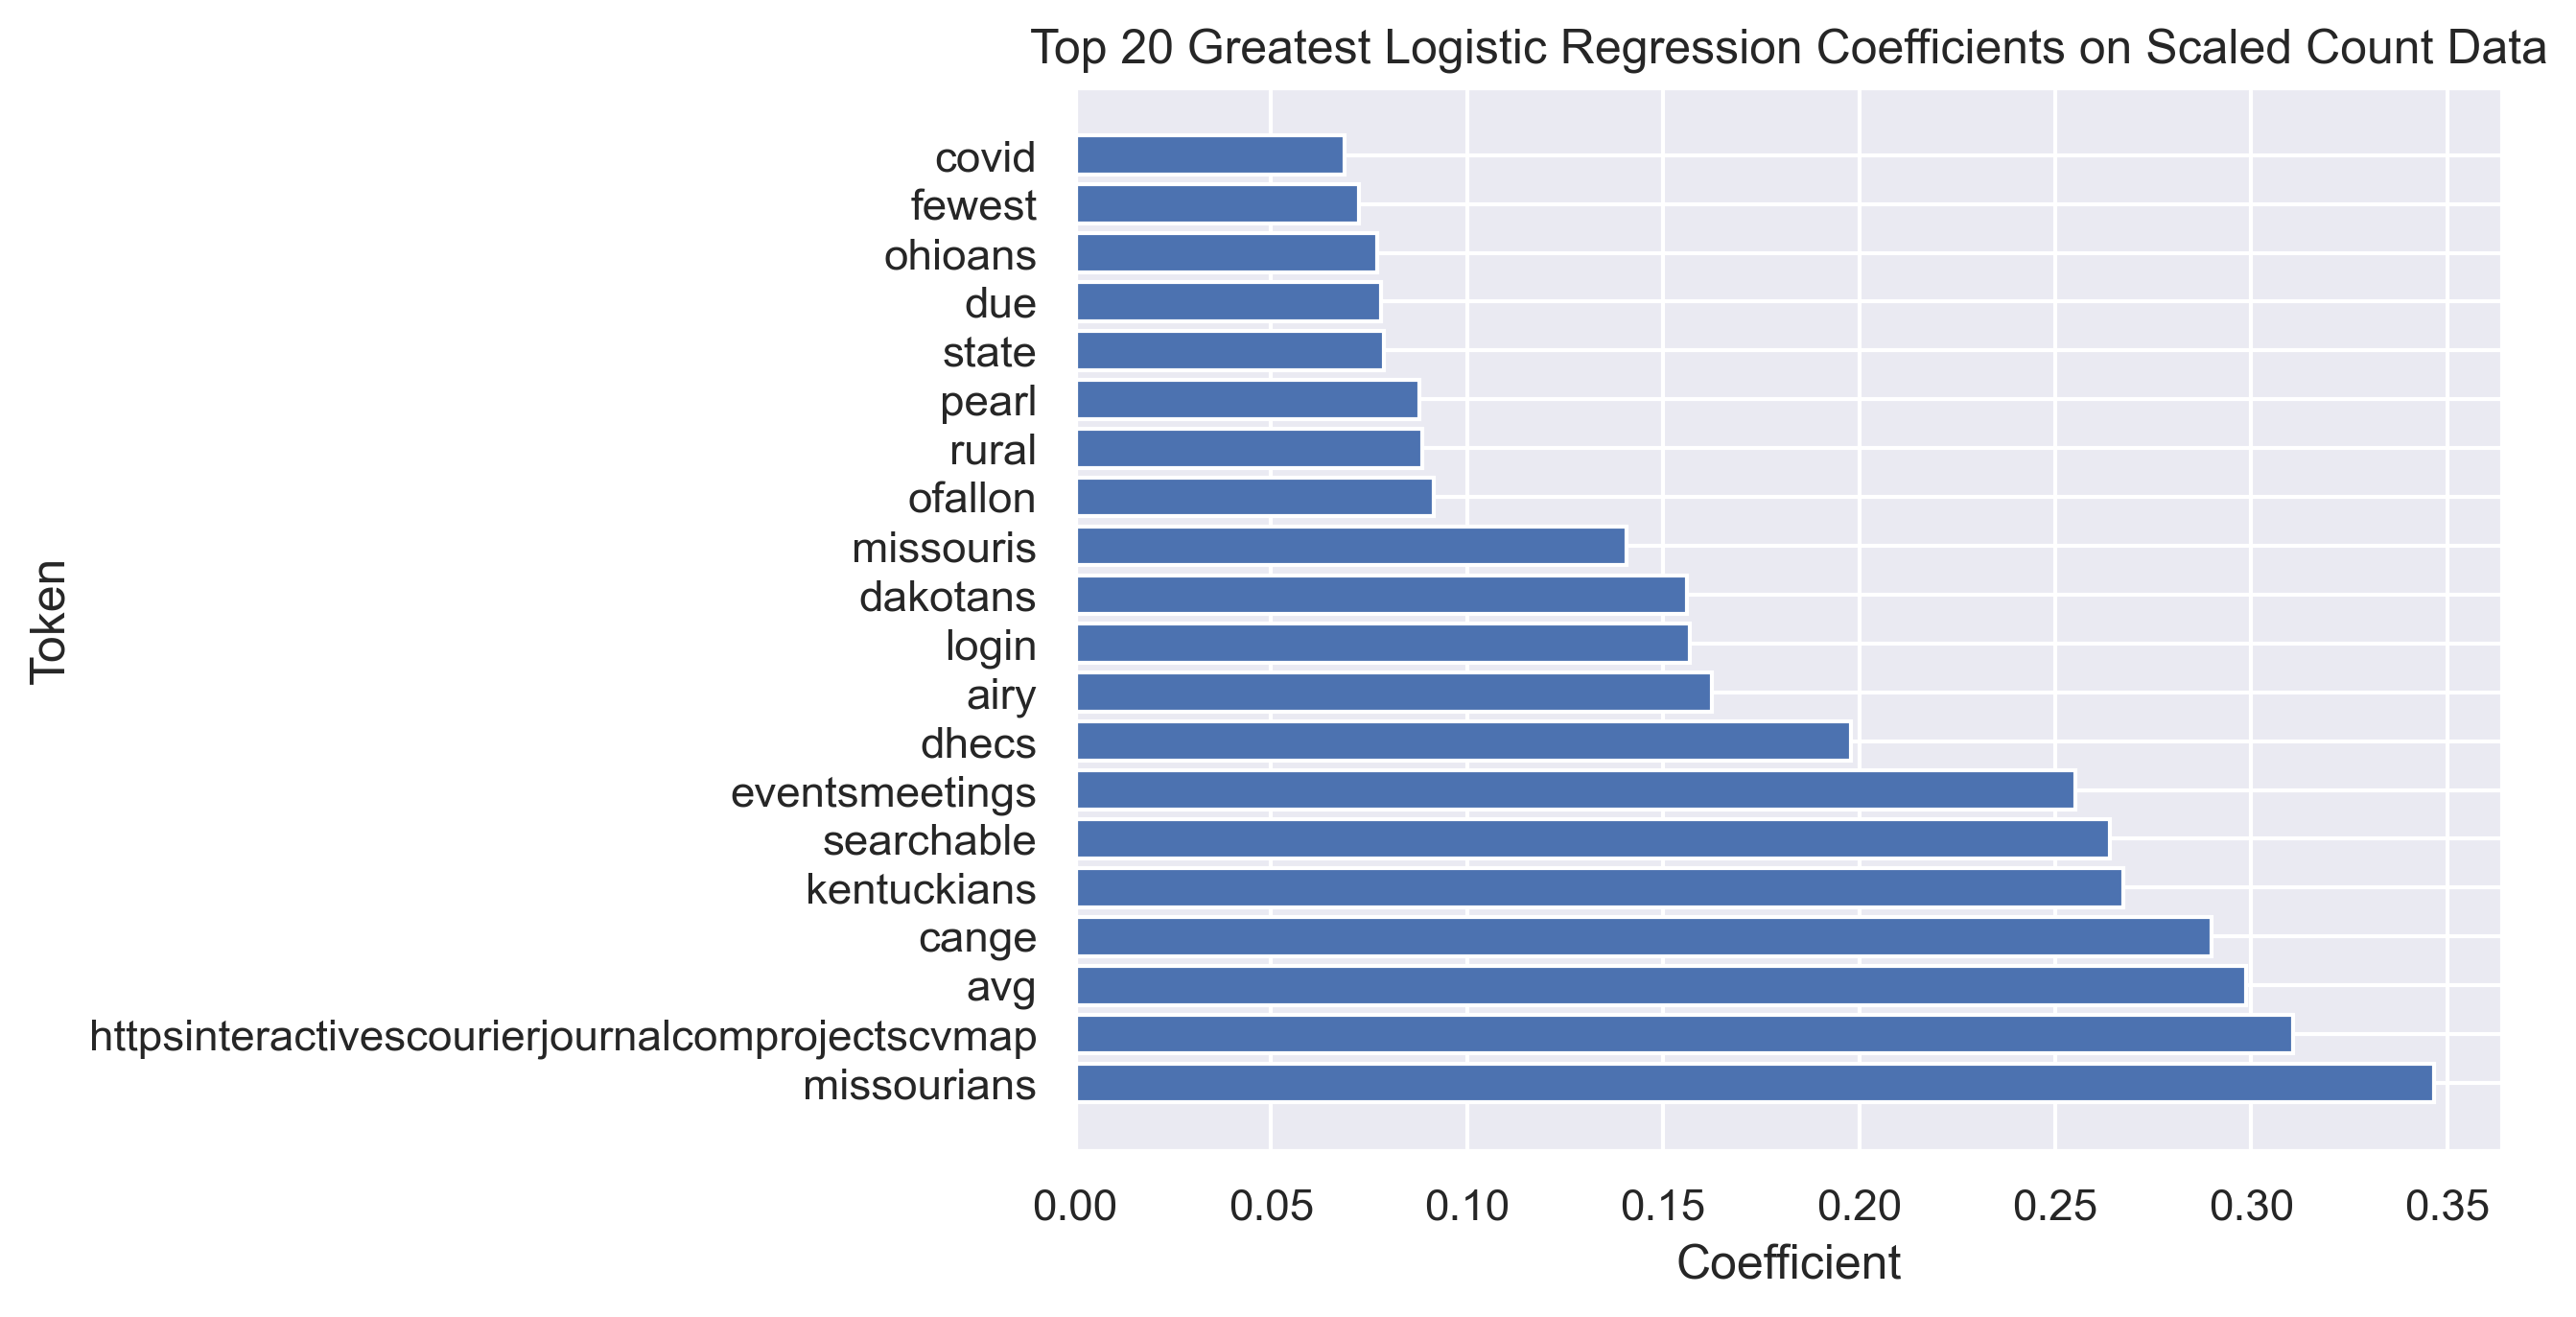

In [57]:
plt.figure(dpi=300)
plt.barh([x[0] for x in a[:20]], [x[1] for x in a[:20]])
plt.title("Top 20 Greatest Logistic Regression Coefficients on Scaled Count Data")
plt.xlabel("Coefficient")
plt.ylabel("Token")

Text(0, 0.5, 'Token')

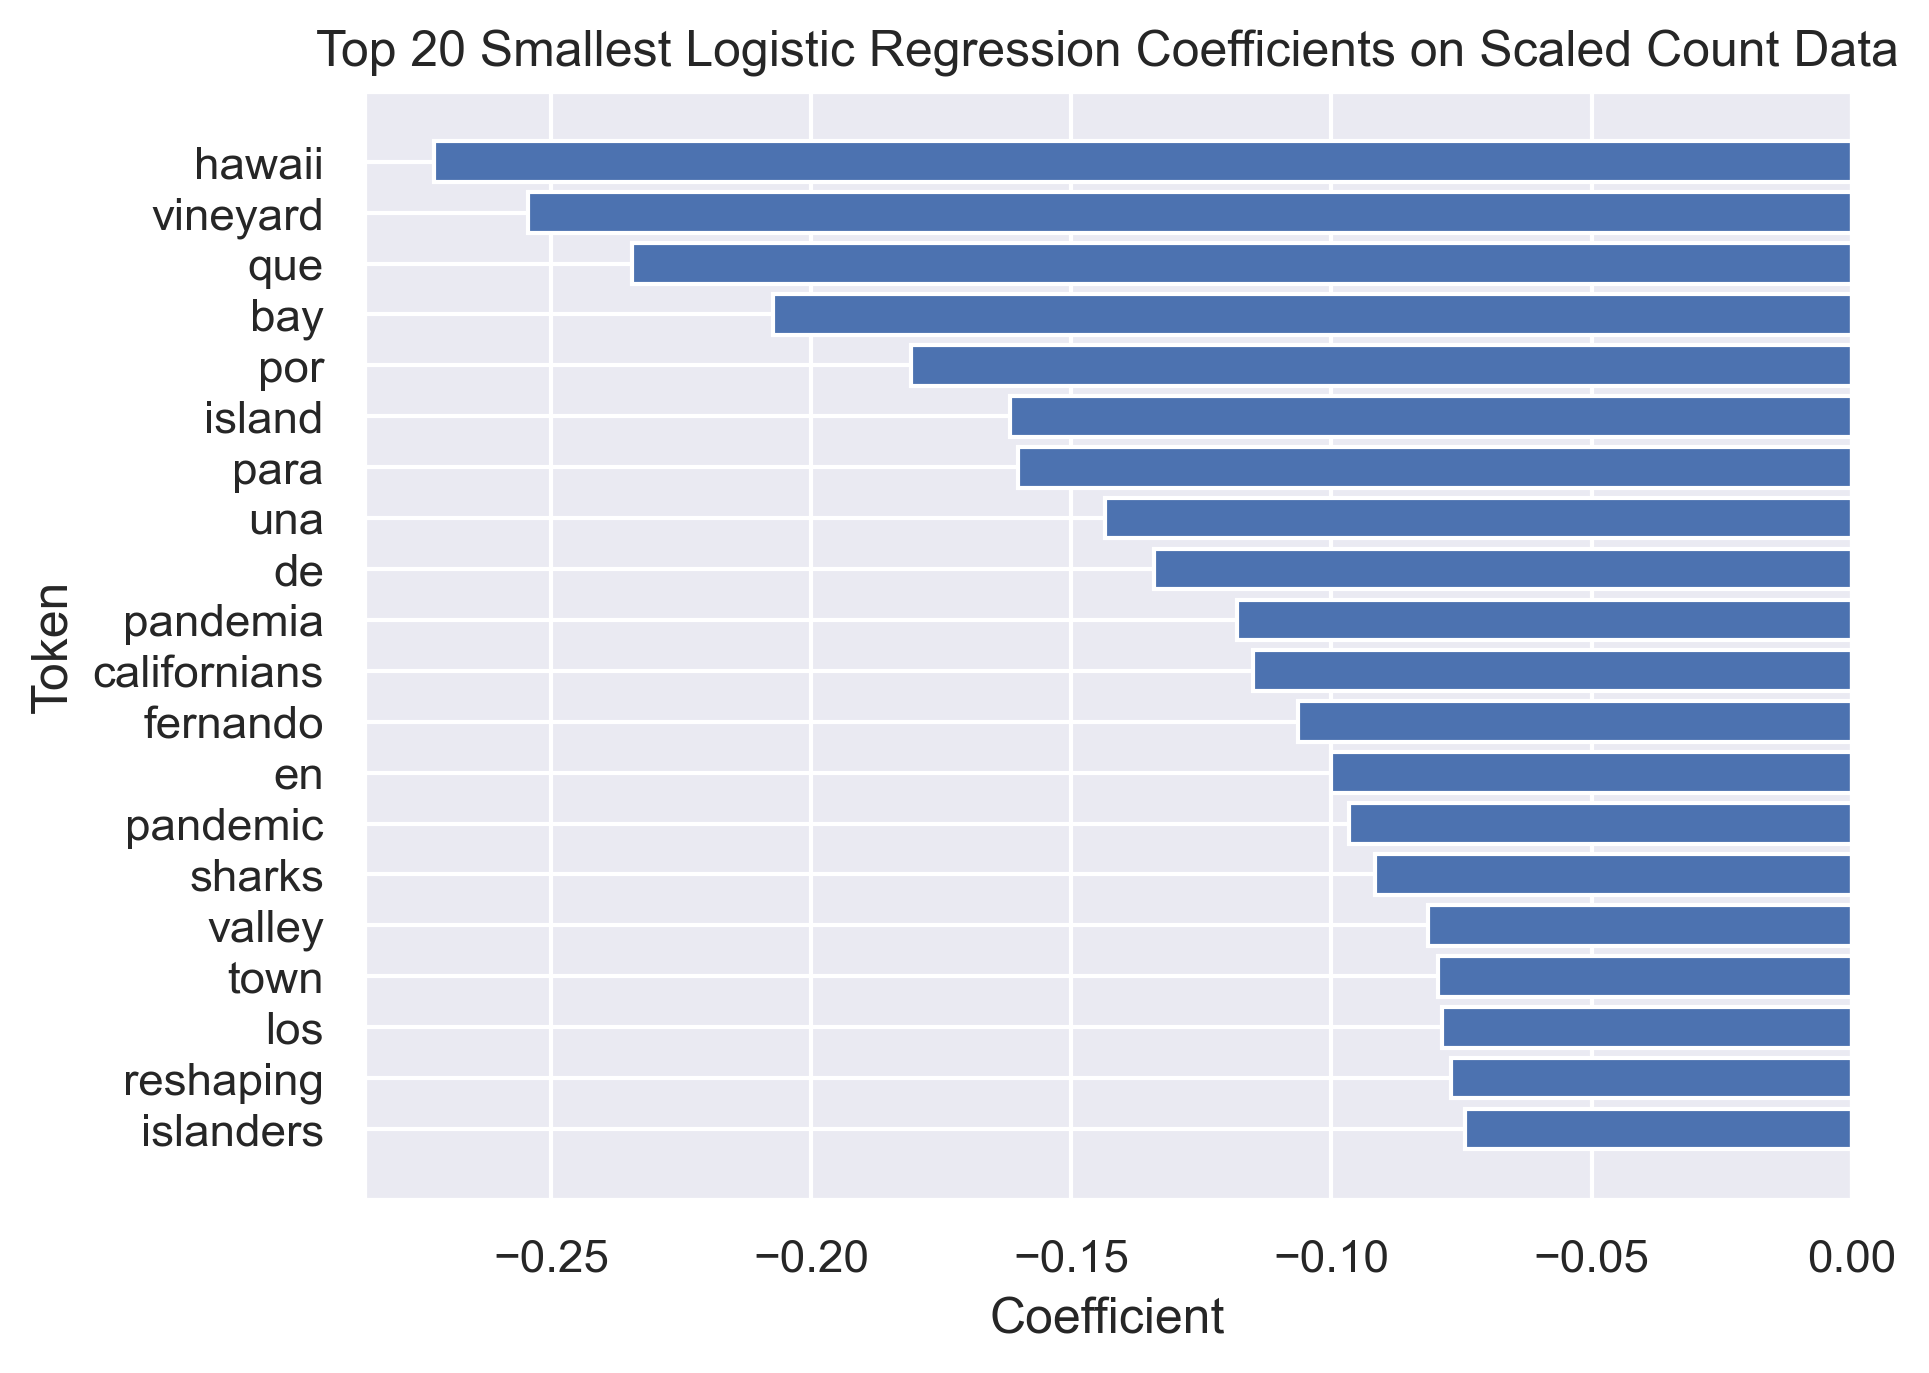

In [58]:
plt.figure(dpi=300)
plt.barh([x[0] for x in a[-20:]], [x[1] for x in a[-20:]])
plt.title("Top 20 Smallest Logistic Regression Coefficients on Scaled Count Data")
plt.xlabel("Coefficient")
plt.ylabel("Token")

In [50]:
lc = list(zip(X_train_count_v.get_feature_names_out(), lr_count.coef_[0]))
lc.sort(key=lambda x: x[1], reverse=True)

In [62]:
lr_s_c = LogisticRegression(max_iter=1000)
%timeit lr_s_c.fit(X_train_count_scaled, y_train)

3.27 s ± 264 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
lr_s_c.score(X_test_count_scaled, y_test)

0.6531

In [23]:
lr_s_c.coef_

array([[-0.0155554 , -0.03304772,  0.0060694 , ...,  0.01216705,
        -0.01169504, -0.04508027]])

In [67]:
lr_count = LogisticRegression(max_iter=1000)
%timeit lr_count.fit(X_train_count, y_train)
lr_count_train_pred = lr_count.predict(X_train_count)
lr_count_test_pred = lr_count.predict(X_test_count)
lr_count_train_acc = (lr_count_train_pred == y_train).mean()
lr_count_test_acc = (lr_count_test_pred == y_test).mean()
print(f"Train accuracy: {lr_count_train_acc}")
print(f"Test accuracy: {lr_count_test_acc}")

9.26 s ± 311 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Train accuracy: 0.6981
Test accuracy: 0.64825


In [64]:
lr_tfidf = LogisticRegression(max_iter=1000)
%timeit lr_tfidf.fit(X_train_tfidf, y_train)
lr_tfidf_train_predictions = lr_tfidf.predict(X_train_tfidf)
lr_tfidf_test_predictions = lr_tfidf.predict(X_test_tfidf)
lr_tfidf_train_accuracy = (lr_tfidf_train_predictions == y_train).mean()
lr_tfidf_test_accuracy = (lr_tfidf_test_predictions == y_test).mean()
print(f"Logistic Regression Train Accuracy: {lr_tfidf_train_accuracy}")
print(f"Logistic Regression Test Accuracy: {lr_tfidf_test_accuracy}")

1.59 s ± 95.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Logistic Regression Train Accuracy: 0.6916
Logistic Regression Test Accuracy: 0.6494


In [117]:
N = 5000
a = pd.DataFrame({"word": words_cdf[:N].index, "coef": lr_count.coef_[0, :N]})

# Discriminative basic_nn


In [14]:
words_cdf

the                     0.065980
to                      0.100449
of                      0.129166
and                     0.155312
in                      0.177433
                          ...   
tsimontontriblivecom    0.999999
lou                     0.999999
musa                    0.999999
offside                 1.000000
wwwaarporgnearyou       1.000000
Name: clean_lines, Length: 40215, dtype: float64

In [16]:
df_s = pd.read_parquet("df_s.parquet")

In [18]:
df_s["encoded"] = df_s.text.apply(encode)

In [38]:
vocab = {word: i + 1 for i, word in enumerate(words_cdf.index[:5000])}

vocab["<PAD>"] = 0

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
X_test_nn = X_test
y_test_nn = y_test


def encode(text):
    return [vocab.get(token, 0) for token in text.split()]


X_train_nn["encoded"] = X_train.clean_lines.apply(encode)
X_val_nn["encoded"] = X_val_nn.clean_lines.apply(encode)
X_test_nn["encoded"] = X_test.clean_lines.apply(encode)

In [39]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X.iloc[idx]["encoded"]), torch.tensor(self.y.iloc[idx])

In [40]:
train_dataset = TextDataset(X_train_nn, y_train_nn)
val_dataset = TextDataset(X_val_nn, y_val_nn)
test_dataset = TextDataset(X_test_nn, y_test_nn)

In [41]:
def collate_batch(batch):
    text_list, label_list = [], []
    for _text, _label in batch:
        text_list.append(_text)
        label_list.append(_label)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    label_list = torch.tensor(label_list, dtype=torch.float32)
    return text_list, label_list

In [42]:
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_batch)

In [43]:
def train_nn(basic_nn, train_loader, val_loader, model_name):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(basic_nn.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")

    for epoch in range(10):
        basic_nn.train()
        train_loss = 0
        for texts, labels in tqdm(train_loader):
            outputs = basic_nn(texts)
            loss = criterion(outputs.squeeze(), labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        basic_nn.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                outputs = basic_nn(texts)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            if not os.path.exists(model_name):
                os.makedirs(model_name)
            best_val_loss = avg_val_loss
            torch.save(basic_nn.state_dict(), f"{model_name}/{model_name}.pth")
        val_losses.append(avg_val_loss)

        print(
            f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}"
        )
    return train_losses, val_losses

In [62]:
basic_nn = TextClassifier(len(vocab), 50)
basic_nn_train_losses, basic_nn_val_losses = train_nn(
    basic_nn, train_loader, val_loader, "basic_nn"
)

C:\Users\19083\AppData\Local\Temp\ipykernel_22592\2091851088.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(self.X.iloc[idx]["encoded"]), torch.tensor(self.y.iloc[idx])


Epoch 1, Train Loss: 0.6805900244712829, Validation Loss: 0.6673595801591873
Epoch 2, Train Loss: 0.6472119025439024, Validation Loss: 0.6464300390481948
Epoch 3, Train Loss: 0.620809906244278, Validation Loss: 0.6372750097513199
Epoch 4, Train Loss: 0.604475511342287, Validation Loss: 0.6342063201665878
Epoch 5, Train Loss: 0.594184308797121, Validation Loss: 0.6336562844514847
Epoch 6, Train Loss: 0.5873500764667988, Validation Loss: 0.6342235339879989
Epoch 7, Train Loss: 0.5826428339481354, Validation Loss: 0.6352792009711266
Epoch 8, Train Loss: 0.5793094107359648, Validation Loss: 0.6365063617825508
Epoch 9, Train Loss: 0.5768920326828957, Validation Loss: 0.637742073237896
Epoch 10, Train Loss: 0.575101117759943, Validation Loss: 0.6389065191745759


Text(0.5, 0, 'Epoch')

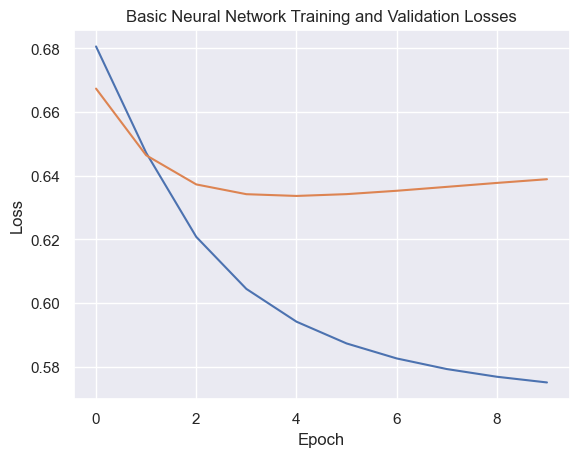

In [63]:
plt.plot(basic_nn_train_losses, label="train")
plt.plot(basic_nn_val_losses, label="validation")
plt.title("Basic Neural Network Training and Validation Losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [2]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc = nn.Linear(embed_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = torch.mean(embedded, dim=1)
        return self.sigmoid(self.fc(pooled))


class TextClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(TextClassifierLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = hidden[-1, :, :]
        dense_outputs = self.fc(hidden)
        outputs = self.sigmoid(dense_outputs)

        return outputs

In [35]:
def evaluate_model(model, test_loader):
    # Store all predictions and true labels
    all_predictions = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for texts, labels in test_loader:
            predictions = model(texts).squeeze(1)
            all_predictions.extend(torch.round(predictions).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate additional metrics
    accuracy = accuracy_score(all_predictions, all_labels)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "predictions": all_predictions,
        "labels": all_labels,
    }

In [44]:
best_basic_nn = TextClassifier(len(vocab), 50)
best_basic_nn.load_state_dict(torch.load("basic_nn/basic_nn.pth"))
results_test = evaluate_model(best_basic_nn, test_loader)
results_train = evaluate_model(best_basic_nn, train_loader)

C:\Users\19083\AppData\Local\Temp\ipykernel_18684\751437801.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(self.X.iloc[idx]["encoded"]), torch.tensor(self.y.iloc[idx])


Accuracy: 0.64
Precision: 0.65
Recall: 0.62
F1 Score: 0.63


C:\Users\19083\AppData\Local\Temp\ipykernel_18684\751437801.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(self.X.iloc[idx]["encoded"]), torch.tensor(self.y.iloc[idx])


Accuracy: 0.69
Precision: 0.69
Recall: 0.67
F1 Score: 0.68


In [86]:
lstm_nn = TextClassifierLSTM(len(vocab), 50, 128, 2)
lstm_nn_train_losses, lstm_nn_val_losses = train_nn(
    lstm_nn, train_loader, val_loader, "lstm_nn"
)
best_lstm_nn = TextClassifierLSTM(len(vocab), 50, 128, 2)

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\19083\AppData\Local\Temp\ipykernel_22592\2091851088.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(self.X.iloc[idx]["encoded"]), torch.tensor(self.y.iloc[idx])
100%|██████████| 2000/2000 [01:39<00:00, 20.13it/s]


Epoch 1, Train Loss: 0.6933200499117375, Validation Loss: 0.6926294177770614


100%|██████████| 2000/2000 [01:52<00:00, 17.81it/s]


Epoch 2, Train Loss: 0.6930599311590194, Validation Loss: 0.6925007160902024


100%|██████████| 2000/2000 [01:46<00:00, 18.77it/s]


Epoch 3, Train Loss: 0.6930107997357845, Validation Loss: 0.69212619805336


100%|██████████| 2000/2000 [01:41<00:00, 19.66it/s]


Epoch 4, Train Loss: 0.6917811736166477, Validation Loss: 0.6904941905736923


100%|██████████| 2000/2000 [01:40<00:00, 19.91it/s]


Epoch 5, Train Loss: 0.6767507715523243, Validation Loss: 0.6644368324279785


100%|██████████| 2000/2000 [01:38<00:00, 20.27it/s]


Epoch 6, Train Loss: 0.6394332578033208, Validation Loss: 0.6450247951745987


100%|██████████| 2000/2000 [01:44<00:00, 19.08it/s]


Epoch 7, Train Loss: 0.6011426155418158, Validation Loss: 0.6433471602201462


100%|██████████| 2000/2000 [01:47<00:00, 18.60it/s]


Epoch 8, Train Loss: 0.5618743085116148, Validation Loss: 0.651822999715805


100%|██████████| 2000/2000 [01:51<00:00, 17.95it/s]


Epoch 9, Train Loss: 0.5170676572918892, Validation Loss: 0.6711930209994316


100%|██████████| 2000/2000 [01:44<00:00, 19.15it/s]


Epoch 10, Train Loss: 0.46698757841438054, Validation Loss: 0.7182941471934319
Accuracy: 0.63
Precision: 0.64
Recall: 0.60
F1 Score: 0.62


In [46]:
best_lstm_nn = TextClassifierLSTM(len(vocab), 50, 128, 2)
best_lstm_nn.load_state_dict(torch.load("lstm_nn/lstm_nn.pth"))
results_lstm_test = evaluate_model(best_lstm_nn, test_loader)
results_lstm_train = evaluate_model(best_lstm_nn, train_loader)

C:\Users\19083\AppData\Local\Temp\ipykernel_18684\751437801.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(self.X.iloc[idx]["encoded"]), torch.tensor(self.y.iloc[idx])


Accuracy: 0.63
Precision: 0.64
Recall: 0.60
F1 Score: 0.62


C:\Users\19083\AppData\Local\Temp\ipykernel_18684\751437801.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(self.X.iloc[idx]["encoded"]), torch.tensor(self.y.iloc[idx])


Accuracy: 0.71
Precision: 0.72
Recall: 0.68
F1 Score: 0.70


Text(0.5, 0, 'Epoch')

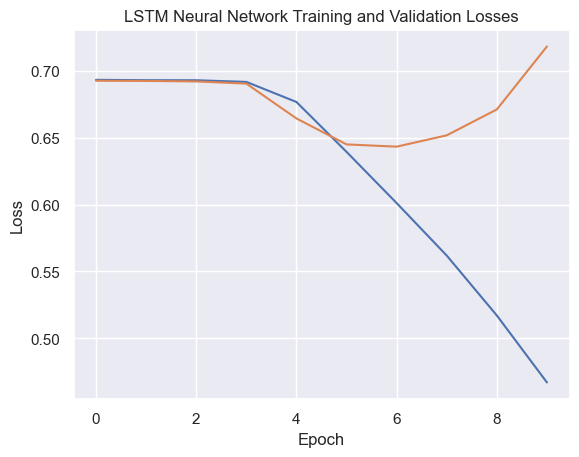

In [87]:
plt.plot(lstm_nn_train_losses, label="train")
plt.plot(lstm_nn_val_losses, label="validation")
plt.title("LSTM Neural Network Training and Validation Losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")

# Synthetic Data


## LSTM


In [27]:
s_dataset = TextDataset(df_s, df_s.trump)
s_loader = DataLoader(s_dataset, batch_size=32, collate_fn=collate_batch)

best_lstm_nn = TextClassifierLSTM(len(vocab), 50, 128, 2)
best_lstm_nn.load_state_dict(torch.load("lstm_nn/lstm_nn.pth"))
results = evaluate_model(best_lstm_nn, s_loader)

C:\Users\19083\AppData\Local\Temp\ipykernel_30768\751437801.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(self.X.iloc[idx]["encoded"]), torch.tensor(self.y.iloc[idx])


Accuracy: 0.64
Precision: 0.65
Recall: 0.62
F1 Score: 0.64


## Basic NN


In [28]:
best_basic_nn = TextClassifier(len(vocab), 50)
best_basic_nn.load_state_dict(torch.load("basic_nn/basic_nn.pth"))
results = evaluate_model(best_basic_nn, s_loader)

C:\Users\19083\AppData\Local\Temp\ipykernel_30768\751437801.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(self.X.iloc[idx]["encoded"]), torch.tensor(self.y.iloc[idx])


Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1 Score: 0.72



(process:8156): Pango-WARNING **: 19:44:24.532: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:16732): Pango-WARNING **: 19:44:24.622: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


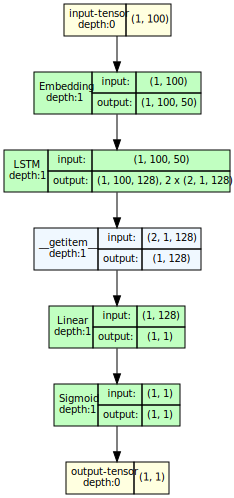

In [60]:
from torchview import draw_graph

model_graph = draw_graph(
    best_lstm_nn,
    torch.zeros(1, 100).long(),
    graph_dir="TB",
    save_graph=True,
    graph_name="lstm",
)
model_graph.visual_graph


(process:35556): Pango-WARNING **: 19:44:21.577: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:17692): Pango-WARNING **: 19:44:21.701: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


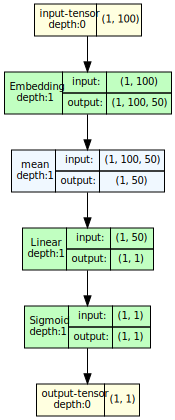

In [59]:
model_graph = draw_graph(
    best_basic_nn,
    torch.zeros(1, 100).long(),
    graph_dir="TB",
    save_graph=True,
    graph_name="basic_nn",
)

model_graph.visual_graph

## LR


In [34]:
lr_count = LogisticRegression(max_iter=1000)
lr_count.fit(X_train_count, y_train)

In [ ]:
X_s_count = X_train_count_v.transform(df_s.text)

In [36]:
lr_count_s_pred = lr_count.predict(X_s_count)
lr_count_s_acc = (lr_count_s_pred == df_s.trump).mean()
print(f"Synthetic data accuracy: {lr_count_s_acc}")

Synthetic data accuracy: 0.7425


In [37]:
p = 0
for param in best_lstm_nn.parameters():
    p += param.numel()

In [38]:
p

474435

In [40]:
pb = 0
for param in best_basic_nn.parameters():
    pb += param.numel()
pb

250101